In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost # conda install py-xgboost
import time
from tqdm import tqdm

In [40]:
fd_001_train = pd.read_csv('C:/Users/Игорь/Downloads/nasa-cmaps/CMaps/train_FD001.txt',header=None,sep=' ')

In [41]:
fd_001_test = pd.read_csv('C:/Users/Игорь/Downloads/nasa-cmaps/CMaps/test_FD001.txt',header=None,sep=' ')

In [42]:
fd_001_train.drop(columns=[26,27],inplace=True)

In [43]:
fd_001_test.drop(columns=[26,27],inplace=True)

In [44]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [45]:
fd_001_train.columns = columns

In [46]:
fd_001_test.columns = columns

In [47]:
# первичное знакомство с данными
fd_001_train.describe()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [9]:
# удалим колонки с константными значениями, как не несущими информацию о состоянии агрегата
fd_001_train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)


## Отобразим взаимные корреляции признаков на "тепловой карте", для этого подготовим дополнительный признак "RUL", показывающий количество циклов до отказа в тренировочных данных

In [10]:
# функция для подготовки тренировочных данных и формирования колонки RUL  с информациеей об оставшихся
#до поломки циклах
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    
    return df[df['time_in_cycles'] > factor]


In [13]:
df = prepare_train_data(fd_001_train)

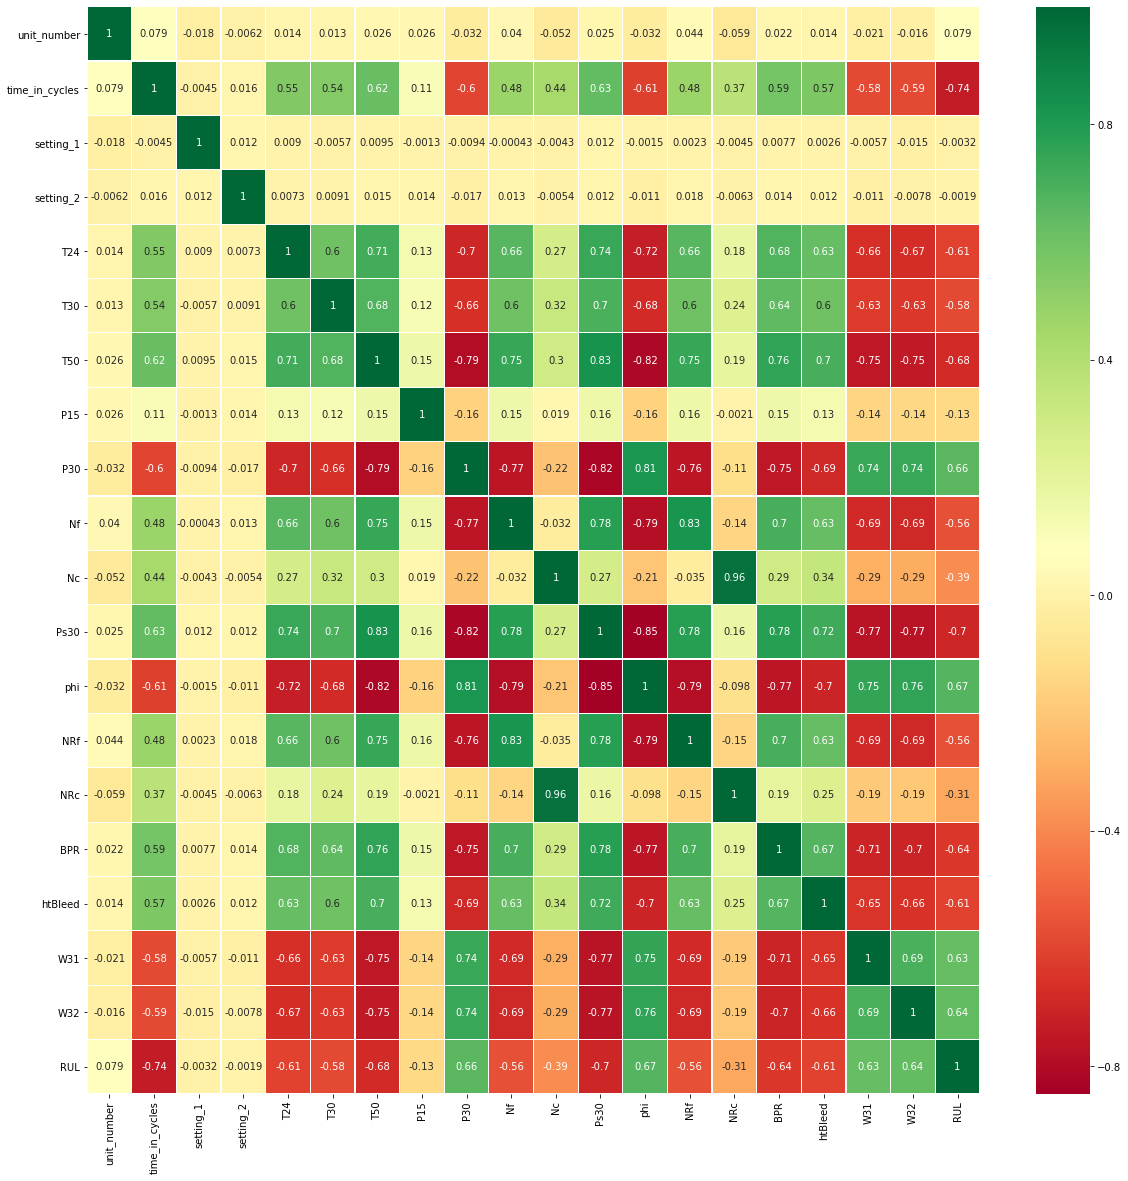

In [14]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

## Функция ошибки для соревновательных данных

<img src="score_function.png">

In [11]:
# функция ошибки для соревновательных данных
def score(y_true,y_pred,a1=10,a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score
    
   

In [12]:
def score_func(y_true,y_pred):
    print(f' соревновательный счет {round(score(y_true,y_pred),2)}')
    print(f' mean absolute error {round(mean_absolute_error(y_true,y_pred),2)}')
    print(f' root mean squared error {round(mean_squared_error(y_true,y_pred),2) ** 0.5}')
    print(f' R2 score {round(r2_score(y_true,y_pred),2)}')
    return
    

## Удалим свойства, слабо коррелирующие с целевым показателем RUL: setting_1, setting_2, P15, unit_number, а также один из признаков, в сильно коррелирующих между собой (Nc и NRc имеют коэффициент корреляции 0.96, удалим NRc)


In [15]:
train_df = df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'])

In [48]:
# функция для создания и тренировки моделей по алгоритмам "Random forest" и "XGBoost"
def train_models(data,model = 'FOREST'):
    X = data.iloc[:,:14].to_numpy() 
    Y = data.iloc[:,14:].to_numpy()
    Y = np.ravel(Y)
    if model == 'FOREST':
         # параметры для моделей подобраны в подобном цикле, с введением в функцию дополнительного параметра param:
         #  for i in range(1,11):
         #     xgb = train_models(train_df,param=i,model="XGB",)
         #     y_xgb_i_pred = xgb.predict(X_001_test)
         #     print(f'param = {i}')
         #     score_func(y_true,y_xgb_i_pred)
        model = RandomForestRegressor(n_estimators=70, max_features=7, max_depth=5, n_jobs=-1, random_state=1)
        model.fit(X,Y)
        return model
    elif model == 'XGB':
        model = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.018, gamma=0, subsample=0.8,
                           colsample_bytree=0.5, max_depth=3,silent=True)
        model.fit(X,Y)
        return model
    return
    

In [49]:
# функция для совместного отображения реальных и предсказанных значений
def plot_result(y_true,y_pred):
    rcParams['figure.figsize'] = 12,10
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('training samples')
    plt.legend(('Predicted', 'True'), loc='upper right')
    plt.title('Сравнение реальных и предсказанных значений ')
    plt.show()
    return

## Подготовим тестовые данные для классификации
нужны только использовавшиеся при тренировке features и строка с максимальным для этого двигателя значением time_in_cycles (последняя)

In [18]:
fd_001_test.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [19]:
test_max = fd_001_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns = ['unit_number','max']

In [20]:
fd_001_test = fd_001_test.merge(test_max, on=['unit_number'], how='left')

In [21]:
test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max']].reset_index()

In [22]:
test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'],inplace = True)

In [23]:
X_001_test = test.to_numpy()

In [24]:
X_001_test.shape

(100, 14)

## Предсказание итогового результата для всех двигателей

##  Обучим модель на тренировочных данных без удаленных свойств 'unit_number','setting_1','setting_2','P15','NRc'

In [25]:
RUL = pd.read_csv('C:/Users/Игорь/Downloads/nasa-cmaps/CMaps/RUL_FD001.txt',header=None,sep=' ')

In [26]:
y_true = RUL[0].to_numpy()

## Средняя абсолютная ошибка и коэффициент детерминации полученной модели:

In [28]:
score_func(y_true, y_pred)

 соревновательный счет 1057.2
 mean absolute error 19.25
 root mean squared error 24.45219826518671
 R2 score 0.65


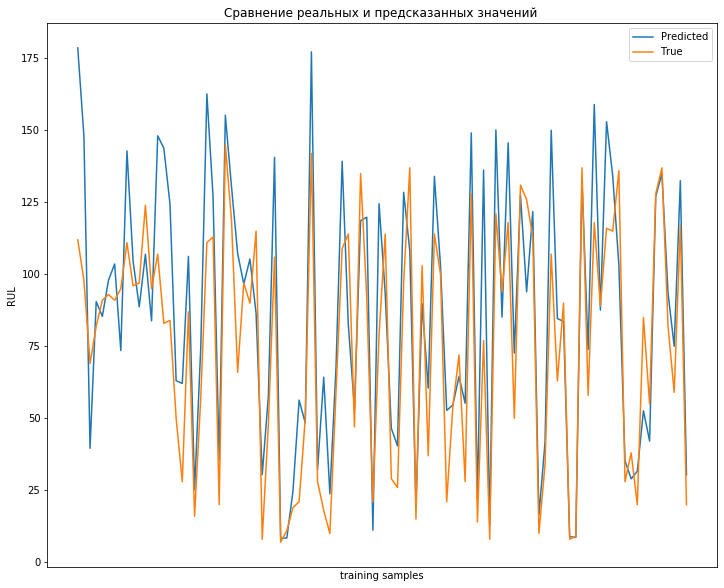

In [29]:
plot_result(y_true,y_pred)

## Попробуем улучшить алгоритм предсказания результатов, для этого будем обучать модель каждый раз заново для каждого отдельного предсказания, отбрасывая в тренировочном массиве значения по временной шкале (значения time_in_cycles) меньшие, чем последнее значение в массиве fd_001_test, то есть меньшие того значения для которого нужно предсказать RUL (remaining useful life)

In [30]:
# для отбрасывания значений в тренировочном массиве используетс параметр factor в 
# функции prepare_train_data, в test_data находятся подготовленные к распознаванию сэмплы, в первом столбце которых 
#  - значение времени в циклах, для которого производится предсказание RUL
def single_train(test_data,train_data,algorithm):
    y_single_pred = []
    for sample in tqdm(test_data):
        time.sleep(1)
        single_train_df = prepare_train_data(train_data, factor = sample[0])
        single_train_df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
        model = train_models(single_train_df,algorithm)
        y_p = model.predict(sample.reshape(1,-1))[0]
        y_single_pred.append(y_p)
    y_single_pred = np.array(y_single_pred)
    return y_single_pred

In [31]:
y_single_pred = single_train(X_001_test,fd_001_train,'FOREST')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.64s/it]


## Отобразим полученные результаты

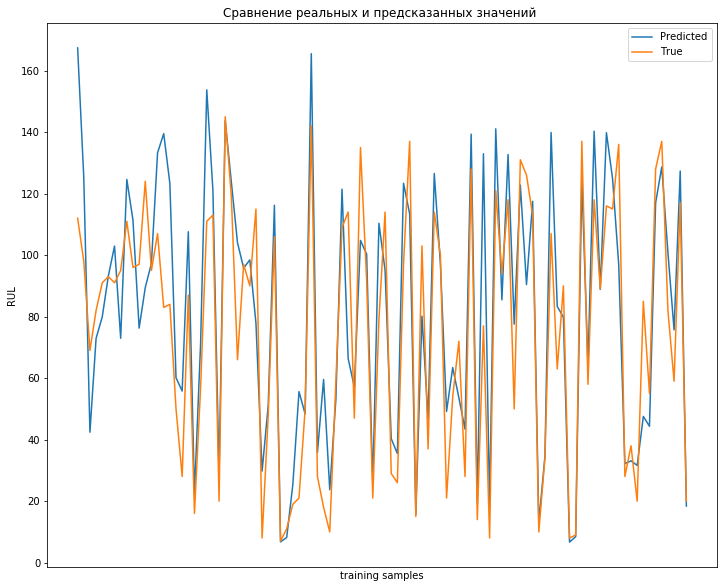

In [32]:
plot_result(y_true,y_single_pred)

## Соревновательный счет, средняя абсолютная ошибка и коэффициент детерминации улучшенной модели

In [33]:
score_func(y_true, y_single_pred)

 соревновательный счет 868.02
 mean absolute error 16.49
 root mean squared error 21.342445970413046
 R2 score 0.74


##   Модифицированным алгоритмом с индивидуальным обучением и предсказанием удалось существенно снизить MAE и повысить R2 score

## Так как данные датчиков сильно зашумлены, для улучшения предсказания попробуем следующий подход: предсказания будем делать на основе не одного (последнего) "среза" значений датчиков, как это делалось выше, а некоторого оптимизируемого (например по коэффициенту детерминации или средней абсолютной ошибки) количества предшествующих поломке значений. Для вывода итогового значения RUL воспользуемся средним значением всех предсказаний

In [34]:
def prepare_test_data(fd_001_test,n=0):
    test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max'] - n].reset_index()
    test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
    X_return = test.to_numpy()
    return X_return

In [35]:
N=5
y_n_pred = y_single_pred
for i in range(1,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = single_train(X_001_test,fd_001_train,'FOREST')    
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred))  

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.67s/it]


## Посчитаем среднее значение предсказаний для каждого двигателя

In [36]:
y_multi_pred = np.mean(y_n_pred,axis = 0)

In [37]:
score_func(y_true,y_multi_pred)

 соревновательный счет 810.53
 mean absolute error 17.78
 root mean squared error 22.172505496673125
 R2 score 0.72


## Отобразим полученные результаты для среднего из 5 предсказаний

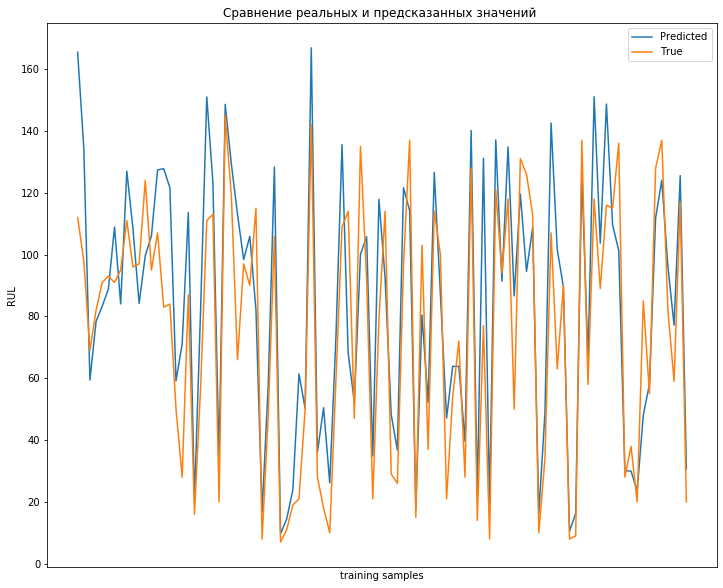

In [38]:
plot_result(y_true,y_multi_pred)

In [ ]:
N=10
#Чтобы повторно не вычислять средний результат для 5 предсказаний, сохраненное значение y_multi_pred 
# заносится в y_n_pred, далее считаются предсказания для 5,6.... строки от последней для данного двигателя
y_n_pred = y_multi_pred
for i in range(5,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = single_train(X_001_test,fd_001_train,'FOREST')    
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred))  

In [ ]:
y_multi_pred_10 = np.mean(y_n_pred,axis = 0)

In [ ]:
score_func(y_true,y_multi_pred_10)

## Отобразим полученные результаты для среднего из 10 предсказаний

In [ ]:
plot_result(y_true,y_multi_pred_10)

## Очевидно, что с дальнейшим ростом числа предсказаний для вывода среднего качество ответов модели не улучшается, в дальнейшем в работе будем использовать y_multi_pred

## Сравним полученные результаты с еще одной моделью - XGBoost

In [113]:
xgb = train_models(train_df,model="XGB")

In [114]:
y_xgb_pred = xgb.predict(X_001_test)

In [115]:
score_func(y_true,y_xgb_pred)

 соревновательный счет 1220.01
 mean absolute error 20.09
 R2 score 0.65


In [ ]:
for i in range(1,100):
    xgb = train_models(train_df,param=i,model="XGB",)
    y_xgb_i_pred = xgb.predict(X_001_test)
    print(f'param = {i}')
    score_func(y_true,y_xgb_i_pred)

## По метрикам оценки алгоритмов регрессии результат немного хуже чем для "случайного леса"
Метрики для RandomForestRegressor

соревновательный счет 1057.2
 
mean absolute error 19.25
 
R2 score 0.65

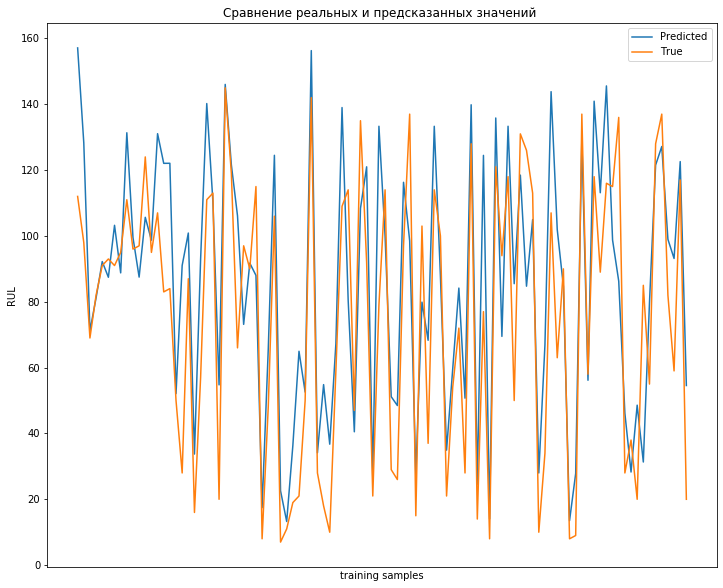

In [116]:
plot_result(y_true,y_xgb_pred)

In [117]:
y_single_xgb_pred = single_train(X_001_test,fd_001_train,'XGB')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.59s/it]


In [169]:
score_func(y_true,y_single_xgb_pred)

 соревновательный счет 1345.22
 mean absolute error 19.23
 mean squared error 535.95
 R2 score 0.69


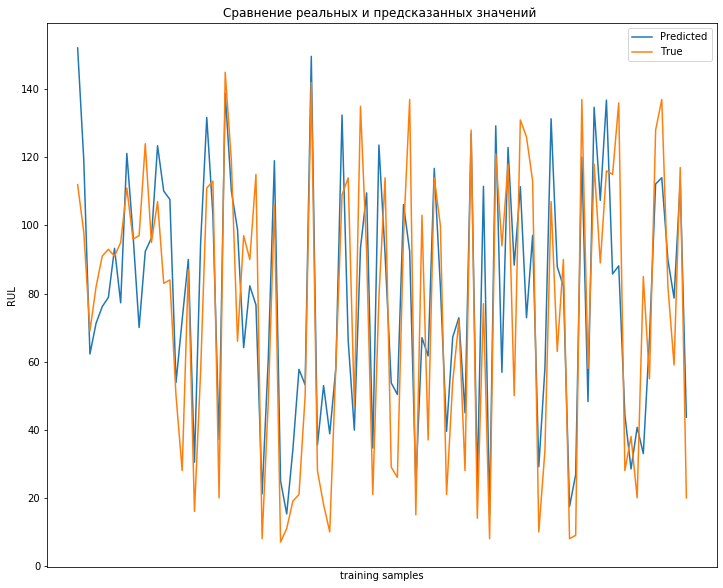

In [140]:
plot_result(y_true,y_single_xgb_pred)

In [ ]:
N=5
y_n_pred = y_single_xgb_pred
for i in range(1,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = single_train(X_001_test,fd_001_train,'XGB')    
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred)) 

In [ ]:
y_5_pred_xgb = np.mean(y_n_pred,axis = 0)

In [ ]:
score_func(y_true,y_5_pred_xgb)

In [ ]:
plot_result(y_true,y_5_pred_xgb)

In [141]:
compare = pd.DataFrame(list(zip(y_true, y_pred, y_single_pred,y_multi_pred,y_multi_pred_10,y_xgb_pred,y_single_xgb_pred)), 
               columns =['True','Forest_Predicted','Forest_Single_predicted','multi_5','multi_10'
                         ,'XGBoost','XGBoost_single']) 
compare['unit_number'] = compare.index + 1

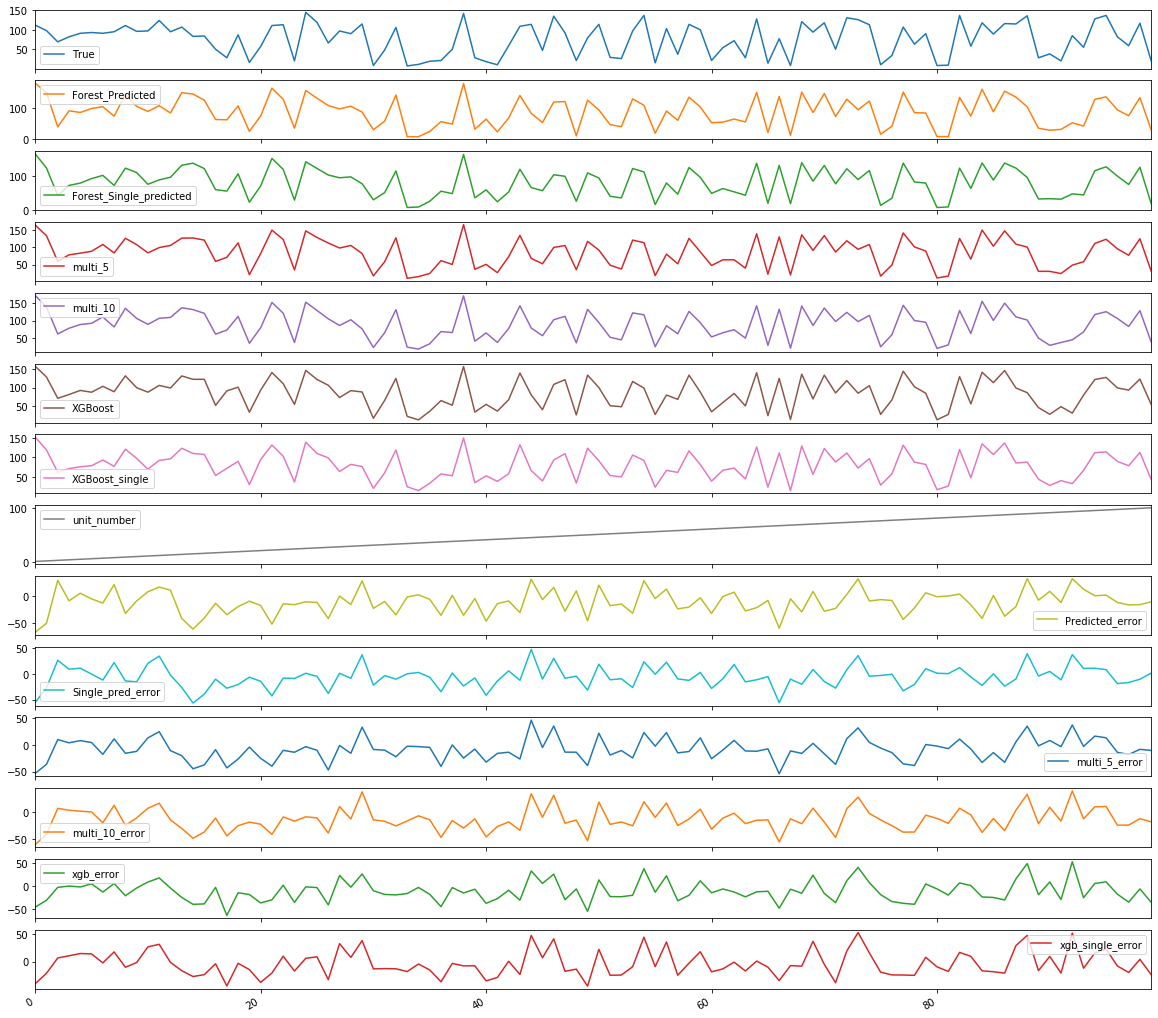

In [142]:
compare['Predicted_error'] = compare['True'] - compare['Forest_Predicted']
compare['Single_pred_error'] = compare['True'] - compare['Forest_Single_predicted']
compare['multi_5_error'] = compare['True'] - compare['multi_5']
compare['multi_10_error'] = compare['True'] - compare['multi_10']
compare['xgb_error'] = compare['True'] - compare['XGBoost']
compare['xgb_single_error'] = compare['True'] - compare['XGBoost_single']
ax1 = compare.plot(subplots=True, sharex=True, figsize=(20,20))

## Ошибки во всех алгоритмах сильно коррелируют, для дальнейшего улучшения прогнозов алгоритма, вероятно нужна предобработка тренировочных и,  возможно тестовых данных для исключения выбросов

## Для получения практической ценности от данных используем алгоритмы бинарной классификации для планирования технического обслуживания ,посчитаем какую прибыль (или убыток) может принести анализ и планирование ТО для гипотетической авиакомпании
https://github.com/Samimust/predictive-maintenance/blob/master/Model%20Selection%20-%20Binary%20Classifiaction.ipynb

## Создадим классификатор, который будет отвечать на вопрос: "Текущий ресурс двигателя больше или меньше 10 циклов" ? Предполагается, что это достаточное время для подготовки и начала технического обслуживания.

## Expected Value Calculation:
Based on the book: Data Science for Business, https://www.amazon.com/Data-Science-Business-Data-Analytic-Thinking/dp/1449361323 . Expected Value is a method to compare different classification models by constructing cost-benefit matrix in line with the confusion matrix, and then convert model performance to a single monetary value by multiplying confusion matrix into the cost-benefit matrix.

Cost-benefit matrix should be designed by domain expert. Let us assume the following:

True Positive (TP) has benefit of USD 300K: engines that need maintenance and correctly selected by the model.

True Negative (TN) has benefit of USD 0K: engines that are OK and not selected by the model.

False Positive (FP) has cost of USD -100K: engines that are OK but selected by the model.

False Negative (FN) has cost of USD -200K: engines that need maintenance but not selected by the model.

In [188]:
train_df.head()

,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32,RUL,label
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191,0
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190,0
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189,0
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188,0
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187,0


In [178]:
TTF = 10
train_df['label'] = np.where(train_df['RUL'] <= TTF, 1, 0 )

Text(0.5, 1.0, 'Диаграмма рассеивания T50 от Nc')

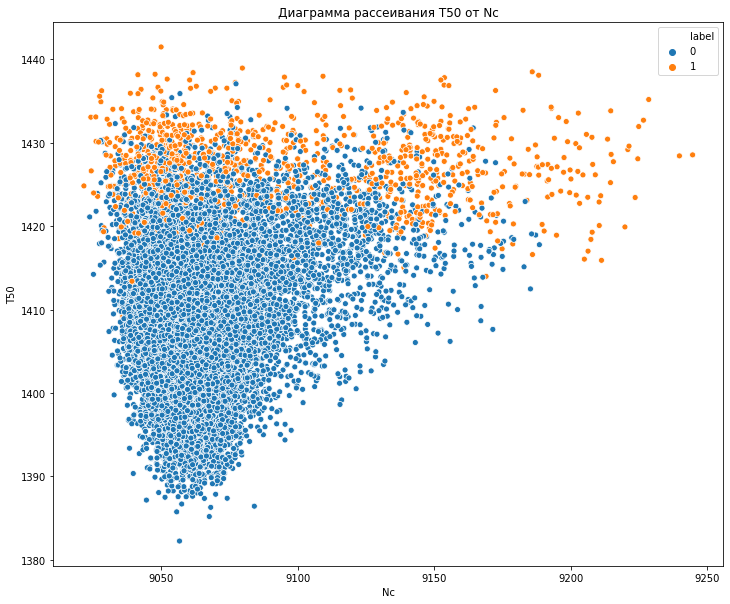

In [187]:
sns.scatterplot(x="Nc", y="T50", hue="label", data=train_df)
plt.title('Диаграмма рассеивания T50 от Nc')

In [193]:
#исключаем свойство RUL и формируем массив признаков и целевой переменной
X_class = train_df.iloc[:,:14].to_numpy() 
Y_class = train_df.iloc[:,15:].to_numpy()
Y_class = np.ravel(Y_class)

In [195]:
# Балансировка классов для улучшения работы классификатора
from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler(random_state=0)
ros.fit(X_class, Y_class)
X_resampled, y_resampled = ros.fit_sample(X_class, Y_class)
print('Количество элементов до операции:', len(X_class))
print('Количество элементов после операции:', len(X_resampled))

Количество элементов до операции: 20631
Количество элементов после операции: 39062


In [196]:
# Здесь делим данные на обучающую выборку и тестовую , test_size = 0.2 задает долю тестовой выборки = 20%
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size = 0.2,random_state = 3)

In [197]:
from sklearn.ensemble import RandomForestClassifier

In [282]:
forest = RandomForestClassifier(n_estimators=70 ,max_depth = 8, random_state=193)

In [283]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
            oob_score=False, random_state=193, verbose=0, warm_start=False)

In [199]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [261]:
def classificator_score(y_,y_p):
    print(f' accuracy score {round(accuracy_score(y_, y_p),2)}')
    print(f' precision score {round(precision_score(y_, y_p),2)}')
    print(f' recall score {round(recall_score(y_, y_p),2)}')
    print(f' F1 score {round(f1_score(y_, y_p),2)}')
    return

In [292]:
classificator_score(y_test,forest.predict(X_test))

 accuracy score 0.98
 precision score 0.96
 recall score 1.0
 F1 score 0.98


In [204]:
test.head()

,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32
0,31,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
1,49,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
2,126,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
3,106,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
4,98,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8.4362,394,38.75,23.4117


In [206]:
X_001_test = test.to_numpy()

In [286]:
# предсказание для X_001_test, время до поломки = TTF =10
predicted = pd.DataFrame(forest.predict(X_001_test))

In [287]:
predicted.columns=['RUL<=10']
predicted['unit_number'] = predicted.index + 1


In [288]:
predicted['RUL']=RUL[0]
predicted['true_label'] = np.where(y_true <= TTF, 1, 0 )

In [289]:
predicted.head()

,RUL<=10,unit_number,RUL,true_label
0,0,1,112,0
1,0,2,98,0
2,0,3,69,0
3,0,4,82,0
4,0,5,91,0


In [293]:
predicted[predicted['true_label'] == 1]

,RUL<=10,unit_number,RUL,true_label
30,1,31,8,1
33,1,34,7,1
41,1,42,10,1
67,1,68,8,1
75,1,76,10,1
80,1,81,8,1
81,1,82,9,1


In [294]:
predicted[predicted['true_label'] != predicted['RUL<=10']]

,RUL<=10,unit_number,RUL,true_label
34,1,35,11,0
35,1,36,19,0
48,1,49,21,0
55,1,56,15,0


In [297]:
y_true_class = np.where(y_true <= TTF, 1, 0 )
y_pred_class = predicted['RUL<=10'].tolist()

In [303]:
def expected_profit(y_true,y_pred):
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(len(y_true)):
        if (y_true[i] != y_pred[i]) & (y_pred[i] == 1):
            FP += 1
        elif (y_true[i] != y_pred[i]) & (y_pred[i] == 0):
            FN += 1
        elif (y_true[i] == y_pred[i]) & (y_pred[i] == 0):
            TN += 1
        else:
            TP += 1
    print(f'TP ={TP}, TN = {TN}, FP = {FP}, FN = {FN}')
    print (f'ожидаемая прибыль {(300 * TP - 200 * FN - 100 * FP) * 1000}')
    return 
        

In [304]:
expected_profit(y_true_class,y_pred_class)

TP =7, TN = 89, FP = 4, FN = 0
ожидаемая прибыль 1700000


## Вывод: предложенный алгоритм классификации показывает полезные результаты на тестовых данных и может использоваться для получения экономии средств при проведении предупредительного ремонта авиадвигателей, для оценки примерного оставшегося ресурса двигателя (если в конкретных условиях допустима соответствующая погрешность) возможно его применение совместно с описанными выше алгоритмами регрессии